In [1]:
import netCDF4 as nc
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
import datetime
import pandas as pd 
import math
from scipy import interpolate
from salishsea_tools.nc_tools import scDataset
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/biology_question/')
import functions_nutrients

import warnings
warnings.filterwarnings("ignore")

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_varbs(dirname, fname, meshmaskname, time_s, time_f, dep_ind_slice):
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    print('files')
    
    y, x = slice(1,-1,None), slice(1,-1,None)
    
    with scDataset(filesT) as dsT, scDataset(filesW) as dsW:
        vosaline0 = dsT.variables['vosaline'][time_s:time_f,dep_ind_slice,y,x]
        print('T')
        vovecrtz0 = dsW.variables['vovecrtz'][time_s:time_f,dep_ind_slice,y,x]
        print('W')
        deptht = dsT.variables['deptht'][:]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        tmask = dsM.variables['tmask'][0,dep_ind_slice,y,x]
        e1t0 = dsM.variables['e1t'][0, y, x] # m
        e2t0 = dsM.variables['e2t'][0, y, x] # m
        e1t = np.cumsum(np.nanmean(e1t0, axis=0)) / 1000 # km
        e2t = np.cumsum(np.nanmean(e2t0, axis=1)) / 1000 # km
    
    return vosaline0, vovecrtz0, deptht, tmask, e1t0, e2t0, e1t, e2t

In [3]:
def get_nutrient(salt_line, nut_line, salt_plan, tmask):

    nut_plan = np.full_like(salt_plan, np.nan)
    f_interp_final = interpolate.interp1d(salt_line, nut_line, fill_value='extrapolate')

    for j in range(salt_plan.shape[-2]):
        for i in range(salt_plan.shape[-1]):
             nut_plan[j,i] = f_interp_final(salt_plan[j,i]) 
    
    return nut_plan

In [4]:
def get_nutrient_flux(salt_line, nut_line, vosaline0, vovecrtz0, tmask, e1t0, e2t0):

    
    print('get_nutrient_flux')
    print('vosaline0', vosaline0.shape)
    print('vovecrtz0', vovecrtz0.shape)
    nut_full = np.full_like(vosaline0, np.nan)
    nut_flux = np.full_like(vosaline0, np.nan)

    for t in range(vosaline0.shape[0]):
        salt_plan = vosaline0[t, :, :]
        nut_plan = get_nutrient(salt_line, nut_line, salt_plan, tmask)
        nut_full[t, :, :] = nut_plan
        nut_flux[t, :, :] = nut_full[t, :, :] * vovecrtz0[t, :, :] * e1t0 * e2t0

    return nut_full, nut_flux

In [5]:
def plot_nutrient_flux(ax, nut_flux_i, nut_flux_r, fs_numb, fs_str):
    
    total_flux_i = np.nansum(np.nansum(nut_flux_i, axis=1), axis=1)
    total_flux_r = np.nansum(np.nansum(nut_flux_r, axis=1), axis=1)
    
    print('nut_flux_i', nut_flux_i.shape)
    print('total_flux_i', total_flux_i.shape)
    
    ax.plot(total_flux_i, c='k', lw=3, ls=':', label='idealized model')
    ax.plot(total_flux_r, c='k', lw=3, ls='-', label='realistic model')
    
    ax.set_xlabel('Time [hours]', fontsize=fs_str)
    ax.xaxis.set_ticks(np.arange(24, 6*24, 24))
    ax.set_xlim([0, 6*24])
    ax.set_ylim([0, 1.5e7])
    ax.set_ylabel('Total nitrate\ntransport\n[mmol s$^{-1}$]', fontsize=fs_str)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.get_offset_text().set_fontsize(fs_numb)
    ax.grid()
    #ax.yaxis.set_ticks(np.arange(0, 25, 5))
    ax.legend(ncol=2, fontsize=fs_numb)
    ax.add_patch(patches.Rectangle((0, 1.2e7),(7),(0.3e7),
                                   fc='w', ec='k', lw=1.5, alpha=1, zorder=8))
    ax.annotate('g', xy=(3.5,1.35e7),
                fontsize=fs_str, weight='bold', va='center', ha='center', zorder=9)
    return ax

In [6]:
def plot_nutrient_plan(ax, nut_array, tmask, time_s_day, e1t, e2t, kind, lab, fs_numb, fs_str):
    
    if kind == 'ideal':
        x_left, y_bottom = 205.822543591543,24.85159075988878
        mid = 306
        ticklabs = np.arange(250,450,50)
    elif kind == 'real':
        x_left, y_bottom = 296.29431501679437, 24.85159075988878
        mid = 400
        ticklabs = np.arange(350,550,50)
        
    vm = 4000
    plot_nutrient_plan
    min_x, max_x, min_y, max_y = mid-100, mid+100, 25, 200
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    ax.yaxis.set_ticks(np.arange(50, 250, 50))
    ax.xaxis.set_ticks(ticklabs)
    
    cmap = cmo.cm.delta
    cmap.set_bad('#8b7765')
    
    time_f_day = time_s_day + 24

    nut_array_daily0 = np.mean(nut_array[time_s_day:time_f_day], axis=0)
    nut_array_daily = np.ma.array(nut_array_daily0, mask=1 - tmask)
    
    print('time_s_day', time_s_day)
    print('nut_array', nut_array.shape)
    print('nut_array_daily', nut_array_daily.shape)
    
    x_shift, y_shift = x_left+e1t, y_bottom+e2t
    p = ax.pcolormesh(x_shift, y_shift, nut_array_daily, cmap=cmap, vmin=-vm, vmax=vm)
    
    ind_y = 180
    ind_y_mid = ind_y + (max_y-ind_y)*0.5
    ax.add_patch(patches.Rectangle((min_x, ind_y),(max_y-ind_y),(max_y-ind_y),
                                   fc='w', ec='k', lw=1.5, alpha=1, zorder=8))
    ax.annotate(lab, xy=(min_x+(max_y-ind_y)*0.5, ind_y_mid),
                fontsize=fs_str, weight='bold', va='center', ha='center', zorder=9)
    
    ax.text(max_x-85, max_y-15, 'Hours '+str(time_s_day+1)+'-'+str(time_s_day+24+1), 
                    fontsize=fs_numb)
    
    return ax, p

In [7]:
def plot_nutrient_column(axes, time_s_day_all, nut_flux, tmask, e1t, e2t, kind, labs, fs_numb, fs_str):
    
    for ax, time_s_day, lab, n in zip(axes, time_s_day_all, labs, np.arange(len(axes))):
        
        ax, p = plot_nutrient_plan(ax, nut_flux, tmask, time_s_day, e1t, e2t, kind, lab, fs_numb, fs_str)

        ax.set_aspect(aspect='equal')
        if kind == 'ideal':
            ax.set_ylabel('Cross-shore (y)\ndistance [km]', fontsize=fs_str)
        if n==2:
            ax.set_xlabel('Alongshore (x)\ndistance [km]', fontsize=fs_str)
            
    return axes, p

# Constants

In [8]:
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

In [9]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

In [10]:
file = '/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/biology_question/LSSL_Geochemistry2009.xls'
sheet = '2009-20_LSSL_Chem'

nutrient = 'phosphate'
PO4_smooth, salt_new = functions_nutrients.get_nutrient_profile(file, sheet, nutrient)

nutrient = 'nitrate'
NO3_smooth, salt_new = functions_nutrients.get_nutrient_profile(file, sheet, nutrient)

phosphate
lat (78,) salt (21,) nut (21,)
nitrate
lat (78,) salt (21,) nut (21,)


In [11]:
time_s_day1 = 24*0 + 11# day 1
time_s_day2 = 24*1 + 11# day 2
time_s_day4 = 24*3 + 11# day 4
time_s_day_all = [time_s_day1, time_s_day2, time_s_day4]

time_s = 0
time_f = 6*24
dep_ind_slice = 6

salt_line, nut_line = salt_new, NO3_smooth

# Ideal

In [12]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

vosaline0_i, vovecrtz0_i, deptht_i, tmask_i, e1t0_i, e2t0_i, e1t_i, e2t_i = get_varbs(dirname, fname, meshmaskname, time_s, time_f, dep_ind_slice)
nut_full_i, nut_flux_i = get_nutrient_flux(salt_line, nut_line, vosaline0_i, vovecrtz0_i, tmask_i, e1t0_i, e2t0_i)

kind = 'real'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

vosaline0_r, vovecrtz0_r, deptht_r, tmask_r, e1t0_r, e2t0_r, e1t_r, e2t_r = get_varbs(dirname, fname, meshmaskname, time_s, time_f, dep_ind_slice)
nut_full_r, nut_flux_r = get_nutrient_flux(salt_line, nut_line, vosaline0_r, vovecrtz0_r, tmask_r, e1t0_r, e2t0_r)


files
T
W
get_nutrient_flux
vosaline0 (144, 242, 272)
vovecrtz0 (144, 242, 272)
files
T
W
get_nutrient_flux
vosaline0 (144, 242, 272)
vovecrtz0 (144, 242, 272)


In [13]:
e1t_i[-1],e2t_i[-1]

(205.15566616759597, 182.24462625887264)

time_s_day 11
nut_array (144, 242, 272)
nut_array_daily (242, 272)
time_s_day 35
nut_array (144, 242, 272)
nut_array_daily (242, 272)
time_s_day 83
nut_array (144, 242, 272)
nut_array_daily (242, 272)
time_s_day 11
nut_array (144, 242, 272)
nut_array_daily (242, 272)
time_s_day 35
nut_array (144, 242, 272)
nut_array_daily (242, 272)
time_s_day 83
nut_array (144, 242, 272)
nut_array_daily (242, 272)
nut_flux_i (144, 242, 272)
total_flux_i (144,)


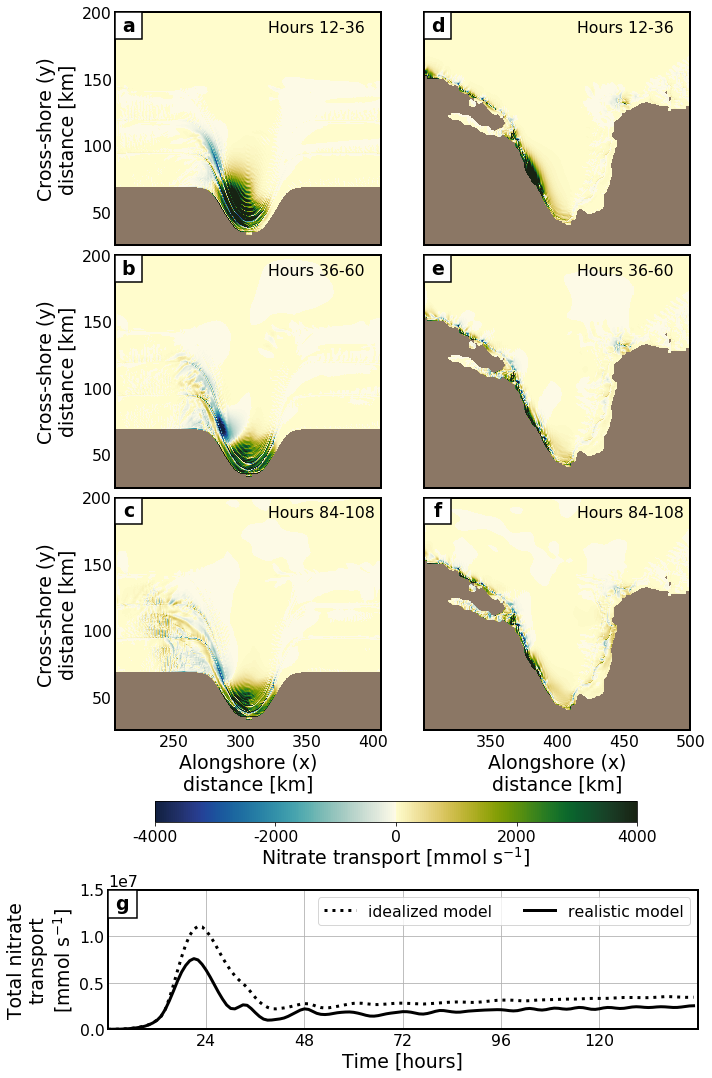

In [14]:
fs_numb, fs_str = 25*0.63, 30*0.63

fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], height_ratios=[1,1,1,0.6,0.6])
ax1i = plt.subplot(gs[0, 0])
ax2i = plt.subplot(gs[1, 0])
ax3i = plt.subplot(gs[2, 0])
ax1r = plt.subplot(gs[0, 1])
ax2r = plt.subplot(gs[1, 1])
ax3r = plt.subplot(gs[2, 1])

axoff = plt.subplot(gs[3,:]); axoff.axis('off')
axlong = plt.subplot(gs[4,:])

axesi = [ax1i, ax2i, ax3i]
axesr = [ax1r, ax2r, ax3r]
labsi = ['a', 'b', 'c']
labsr = ['d', 'e', 'f']

for ax in ([ax1r, ax2r, ax3r]):
    ax.yaxis.set_tick_params(labelbottom=False)
    
for ax in ([ax1i, ax1r, ax2i, ax2r]):
    ax.xaxis.set_tick_params(labelbottom=False)

for ax in (ax1i, ax2i, ax3i, ax1r, ax2r, ax3r, axlong):  
    ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)


axesi, p = plot_nutrient_column(axesi, time_s_day_all, nut_flux_i, tmask_i, e1t_i, e2t_i, 'ideal', labsi, fs_numb, fs_str)
axesr, p = plot_nutrient_column(axesr, time_s_day_all, nut_flux_r, tmask_r, e1t_r, e2t_r, 'real', labsr, fs_numb, fs_str)

ticks = np.arange(-4000, 4500, 2000)
cbaxes = fig.add_axes([0.22, 0.24, 0.67, 0.02])
cbar = fig.colorbar(p, format='%1.f', ax=ax3r, cax=cbaxes, orientation='horizontal', ticks=ticks)
cbar.ax.tick_params(labelsize=fs_numb)
cbar.ax.set_xlabel('Nitrate transport [mmol s$^{-1}$]', fontsize=fs_str, labelpad=0.2)

axlong = plot_nutrient_flux(axlong, nut_flux_i, nut_flux_r, fs_numb, fs_str)

fig.tight_layout()
fig.patch.set_facecolor('white')    
plt.subplots_adjust(top=0.99, wspace=0.1, hspace=0.05)
fig.savefig('./fig_nitrate_flux.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

In [15]:
area = (207e3)*(184e3)
time_hr = 1.5*24
time_s = time_hr*60*60

In [16]:
total_flux_i_sect = np.nansum(np.nansum(np.nansum(nut_flux_i, axis=1), axis=1)[:int(time_hr)])
total_flux_r_sect = np.nansum(np.nansum(np.nansum(nut_flux_r, axis=1), axis=1)[:int(time_hr)])

max_flux_i_sect = np.nanmax(np.nansum(np.nansum(nut_flux_i, axis=1), axis=1)[:int(time_hr)])
max_flux_r_sect = np.nanmax(np.nansum(np.nansum(nut_flux_r, axis=1), axis=1)[:int(time_hr)])

from decimal import Decimal

print('total flux')
print('ideal', '%.2E' % Decimal(str(total_flux_i_sect)))
print('real', '%.2E' % Decimal(str(total_flux_r_sect)))

print('\nmax flux')
print('ideal', '%.2E' % Decimal(str(max_flux_i_sect)))
print('real', '%.2E' % Decimal(str(max_flux_r_sect)))

drawdown_seasonal = 150
print('\ntotal drawdown')
drawdown_i = total_flux_i_sect * time_s / area
drawdown_r = total_flux_r_sect * time_s / area
print('value')
print('ideal', drawdown_i)
print('real', drawdown_r)
print('percentage')
print('ideal', drawdown_i/drawdown_seasonal*100)
print('real', drawdown_r/drawdown_seasonal*100)

print('\nmax drawdown')
drawdown_im = max_flux_i_sect * time_s / area
drawdown_rm = max_flux_r_sect * time_s / area
print('value')
print('ideal', drawdown_im)
print('real', drawdown_rm)
print('percentage')
print('ideal', drawdown_im/drawdown_seasonal*100)
print('real', drawdown_rm/drawdown_seasonal*100)

total flux
ideal 1.65E+08
real 1.02E+08

max flux
ideal 1.11E+07
real 7.59E+06

total drawdown
value
ideal 560.0582472589792
real 347.7091236294896
percentage
ideal 373.37216483931945
real 231.80608241965976

max drawdown
value
ideal 37.60229943289225
real 25.8249011342155
percentage
ideal 25.068199621928166
real 17.21660075614367
